In [1]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [3]:
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/tiwat/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY2.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ

    waveform_csv = np.array(iq_val[:230401])    # 10 ms
    # waveform_csv = np.array(iq_val)

print("len(waveform)", len(waveform_csv))
print("sample waveform_csv")
waveform_csv[:5]

len(waveform) 230401
sample waveform_csv


array([-0.00123117-0.00102036j,  0.00109794-0.00055222j,
        0.00108245-0.00025547j,  0.00074913-0.00107994j,
        0.00054957-0.00111326j])

In [3]:
# downsampling, low pass filter
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')
print("len(waveform)",len(waveform))
print("waveform after decimate:",waveform[:5])

# scale up max amplitude to 1
waveform /= max(waveform.real.max(), waveform.imag.max())
print("waveform scale max amplitude to 1:",waveform[:5])

samplingRate = 23.04e6
fs = samplingRate // dec_factor     # floor devision   

len(waveform) 28801
waveform after decimate: [ 0.00039785-0.00057816j  0.00049174-0.00041159j -0.00012423+0.00074921j
 -0.00019332+0.00036641j -0.00030398+0.00052994j]
waveform scale max amplitude to 1: [ 0.16179951-0.23512766j  0.19998263-0.167384j   -0.05051995+0.30468921j
 -0.07861919+0.1490128j  -0.12362406+0.21551413j]


In [31]:
t = np.arange((len(waveform)/fs)*1e3)   # 10 ms

In [26]:
scs = 30
syncNfft = 256
syncSR = int(syncNfft * scs * 1e3)
scipy.signal.resample(waveform, syncSR)

array([0.16179951-0.23512766j, 0.16211793-0.23636639j,
       0.16243185-0.23760308j, ..., 0.16081647-0.23140063j,
       0.16114887-0.23264464j, 0.16147652-0.23388703j])

In [117]:
carrier = nrCarrierConfig(NSizeGrid = 20, SubcarrierSpacing = scs)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']

pssIndices = np.arange((119-63), (119+64))
NID2 = 2
refGrid = np.zeros((20*12,2))
refGrid[pssIndices,1] = nrPSS(NID2)
print('refGrid:',refGrid[1], refGrid[100])
nslot = 0

slotGrid = nrResourceGrid(carrier)
slotGrid = slotGrid[:, 0]
slotGrid[pssIndices] = nrPSS(NID2)
print(slotGrid[1], slotGrid[56])

refGrid: [0. 0.] [0. 1.]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Try to do code, may miss some step

In [188]:
sampleRate = 23.04e6
scsSSB = 30
searchBW = 6*scsSSB

# shift by half scs step
fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2
print('fshifts:', fshifts)
t = np.arange(len(waveform_csv))/sampleRate
coarseFrequencyOffset = fshifts[0]
print('coarseFrequencyOffset:', coarseFrequencyOffset)

# shift frequency by coarseFrequencyOffset
rxWaveformFrquencyCorrect = waveform_csv*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
print('rxWaveformFrquencyCorrect:', rxWaveformFrquencyCorrect)

# downsample
syncNfft = 256   
syncSR = syncNfft* scsSSB * 1e3
rxWaveformDS = scipy.signal.resample_poly(rxWaveformFrquencyCorrect, syncSR, sampleRate)
rxWaveformDS.shape

fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]
coarseFrequencyOffset: -90000.0
rxWaveformFrquencyCorrect: [-0.00123117-0.00102036j  0.00111116-0.00052511j  0.00109368-0.00020204j
 ... -0.00213862+0.00075829j -0.0020745 -0.0010074j
 -0.00108961-0.00154664j]


(76801,)

In [22]:
nrbSSB = 20
refGrid = np.zeros((nrbSSB*12, 2))

# create refGrid that at column 1 has PSS symbol at kPSS indices
NID2 = 0
kPSS = np.arange(57, 184)
refGrid[kPSS,1] = nrPSS(NID2)
refGrid[55:59]      # print check

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 0., -1.]])

In [205]:
nSlot = 0
# [~, corr] = nrTimingEstimate(rxWaveformDS, nrbSSB, scsSSB, nSlot, refGrid, 'SampleRate'= syncSR, 'Nfft', syncNfft)


T = len(rxWaveformDS)
print( 'waveform_csv.shape', waveform_csv.shape[0],'length T', T)

# However, we want to OFDM modulate but couldn't so we create slotGrid that work the same, 
# where slotGrid has 14 columns same with 14 OFDM symbols, and PSS is located at symbol #2 at index kPSS
carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
slotGrid = nrResourceGrid(carrier)
# slotGrid[kPSS, 2] = nrPSS(NID2)
# slotGrid[56:58]

# How about we set only 2 columns like refGrid example
slotGrid = slotGrid[:,:2]
slotGrid[kPSS, 1] = nrPSS(NID2)
slotGrid[56:59]

waveform_csv.shape 230401 length T 76801


array([[ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j],
       [ 0.+0.j, -1.+0.j]])

In [206]:
[ref, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft = syncNfft, SampleRate = syncSR)
# print('ref', ref)

ref = ref[info['CyclicPrefixLengths'][0]:]; # remove CP

In [207]:
# current ref waveform is a lot shorter than the rxWaveformDS
minlength = ref.shape[0]
print('minlength', minlength)

# pad input waveform if it is shorter than the reference waveform

if T < minlength:
    pad = np.zeros(minlength-T, dtype=rxWaveformDS.dtype)
    waveformPad = np.concatenate((rxWaveformDS, pad))
else:
    waveformPad = rxWaveformDS
    
waveformPad.shape

minlength 1078


(76801,)

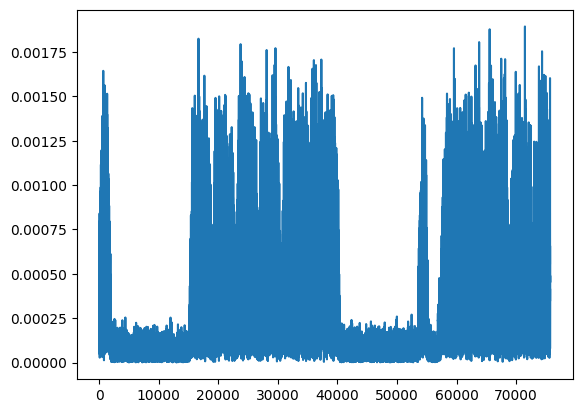

In [208]:
# temp = scipy.signal.correlate(waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
refcorr = scipy.signal.correlate(rxWaveformDS, ref, 'valid')
mag = np.argmax(np.abs(refcorr))
t_corr = np.arange(refcorr.shape[0])
plt.plot(t_corr, np.abs(refcorr))

